In [4]:
import pandas as pd
import numpy as np 
import matplotlib as plt 
import seaborn as sns 

plt.style.use('ggplot')

import nltk
import json 

In [8]:
#Read the sample json 
data = json.load(open('../scraping/test_sample.json'))

In [10]:
match = "Liverpool vs Chelsea" #This will be an input from the user through main, TBU 
teams = [team.lower() for team in match.split(' vs ')]

#Structure the raw data into a dataframe, every sentence will be a row in the dataframe
row=[]
for title, value in data.items():
    title=title
    description = value['description']
    comments = value['comments']

    messages=[title,description]+comments

    for message in messages:
        message=message.lower()

        #Check if the message contains any of the teams
        if teams[0] in message and teams[1] not in message:
            row.append({"team":teams[0],"message":message})
        elif teams[1] in message and teams[0] not in message:
            row.append({"team":teams[1],"message":message})
        '''
        For now, we are not considering the messages that contain both teams.
        However, we will have to consider them in the future, as they might contain useful information. 
        '''

#Now create the dataframe
df = pd.DataFrame(row)


<Axes: title={'center': 'Number of messages per team'}, xlabel='team'>

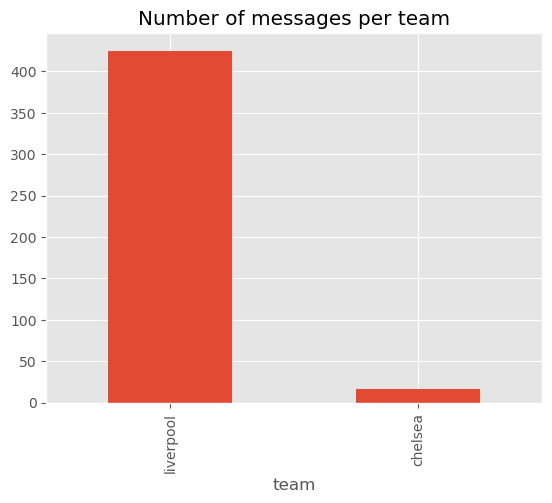

In [12]:
df['team'].value_counts().plot(kind='bar',title='Number of messages per team')